In [1]:
import theano
import theano.tensor as T
import numpy as np
import cv2
import sys
from loader import PatchLoader

/usr/local/lib/python2.7/dist-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6021 on context None
Mapped name None to device cuda: GeForce GT 740M (0000:01:00.0)


In [2]:
from easydict import EasyDict
cfg = EasyDict()
cfg.SEQ_LENGTH = 250
cfg.TILE_SIZE = 9
cfg.OUT_SIZE = 1
cfg.gm_num = 4
cfg.ndim = 12
cfg.NAME_PREFIX = ''
cfg.NETWORK = 'conv4_net_dense'
cfg.NAME='experiments/'+cfg.NAME_PREFIX+cfg.NETWORK+'%d'%(cfg.ndim)

cfg.TRAIN = EasyDict()
cfg.TRAIN.EPOCH = 0
cfg.TRAIN.TRIN_EPOCH_SIZE = 1500
cfg.TRAIN.TEST_EPOCH_SIZE = 750
cfg.TRAIN.EPOCH_NUM = 20

cfg.DATASET = EasyDict()
cfg.DATASET.TRAIN_MINR = 0.2
cfg.DATASET.TRAIN_MAXR = 0.3
cfg.DATASET.TEST_MINR = 0.2
cfg.DATASET.TEST_MAXR = 0.3
cfg.DATASET.T_SIZE = 32
cfg.DATASET.CASHE_SAMPLES = True

In [3]:

train_loader = PatchLoader('data/train_%d'%cfg.DATASET.T_SIZE,
                           cfg.DATASET.T_SIZE,
                           cfg.SEQ_LENGTH,
                           cfg.DATASET.TRAIN_MINR,
                           cfg.DATASET.TRAIN_MAXR,
                           cfg.TILE_SIZE,
                           cfg.DATASET.CASHE_SAMPLES)

(250, 3, 9, 9) (250, 9, 9)
15771.0 3879.0


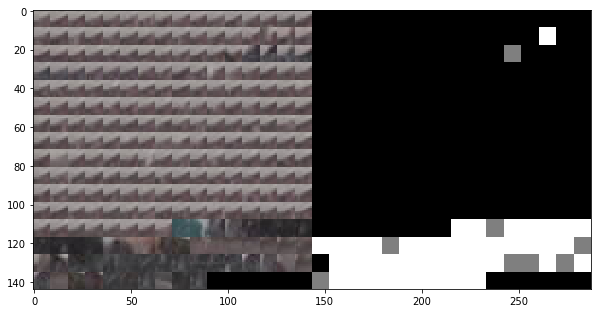

In [4]:
from dataset_tools import draw
from loader import data_generator
import matplotlib.pyplot as plt
%matplotlib inline
for x,y in data_generator(train_loader,epoch_size=1,shuffle=False):
    print x.shape,y.shape
    print np.ones_like(y)[y<0.1].sum(),np.ones_like(y)[y>0.9].sum()
    x = np.transpose(x,(0,2,3,1)).astype(np.uint8)
    y = (y*255.).astype(np.uint8)
    _y = np.zeros(x.shape[:3],dtype=np.uint8)
    
    _y[:] = y[:,0,0][:,None,None]
    draw(x,_y)

# Build model

# Train

In [4]:
from gmm_op import get_gmm,calc_log_prob_gmm
from theano_utils import split,histogram_loss,split_tr_p_n
import lasagne
from networks import make_FCN


def make_classifier(X,label,non_learn_params):
    X = X.reshape((-1,X.shape[-1]))
    x_tr,x_p,x_n = split_tr_p_n(X,label.flatten())
    m,c,w = get_gmm(x_tr,
                    gm_num = non_learn_params['gm_num'],
                    ndims = non_learn_params['ndim'],
                    use_approx_grad=non_learn_params['use_approx_grad'])
    p_n = calc_log_prob_gmm(x_n,m,c,w)
    p_p = calc_log_prob_gmm(x_p,m,c,w)
    loss = histogram_loss(p_n,p_p,
                          non_learn_params['min_cov'],
                          non_learn_params['histogram_bins'],
                          non_learn_params['width'])[0]
    prediction = T.nnet.sigmoid(T.concatenate([p_p,p_n],axis=0))
    Y = T.concatenate([T.ones_like(p_p),T.zeros_like(p_n)],axis=0)
    return loss,X,Y,prediction,m,c,w,p_p,p_n

def make_train(net,data,label,non_learn_params):
    sym = L.get_output(net ,deterministic=False)
    s = int((L.get_output_shape(net)[1]-1)/2)
    sym = sym[:,s:s+1,s:s+1,:]
    loss,X,Y,prediction,m,c,w,p_p,p_n = make_classifier(sym,label[:,s:s+1,s:s+1],non_learn_params)
    params = L.get_all_params(net,trainable=True)
    grads = T.grad(loss,params)
    if( 'total_grad_constraint' in non_learn_params.keys()):
        grads = lasagne.updates.total_norm_constraint(grads,non_learn_params['total_grad_constraint'])
    updates = lasagne.updates.adam(grads,params,non_learn_params['lr'])
    return theano.function([data, label], [loss,X,Y,prediction,m,c,w,p_n,p_p],\
                               allow_input_downcast=True, updates=updates)


In [10]:
from sklearn.metrics import average_precision_score
import datetime
import os
from test_tools import make_test,GMMAlgorithm
from utils import Logger
from train_tools import iterate_batches

def update_params(epoch,params):
    if(epoch == 0):
        params['min_cov'].set_value(1e-4)
        params['lr'].set_value(5e-1)
    if(epoch == 4):
        params['min_cov'].set_value(1e-8)
        params['lr'].set_value(5e-2)          
    if(epoch == 10):
        params['min_cov'].set_value(1e-8)
        params['lr'].set_value(5e-3)
    if(epoch == 15):
        params['lr'].set_value(1e-4)
    
def train_network(cfg):   
    metrix = {'aps' : average_precision_score,
              'f1' : lambda y,s : metrics.f1_score(y,bin_score(s)),
              'acc' : lambda y,s : metrics.accuracy_score(y,bin_score(s))}

    non_learn_params={'min_cov' : theano.shared(1e-3),
                      'lr' : theano.shared(np.array(1e-2, dtype=theano.config.floatX)),
                      'width': theano.shared(4.),
                      'total_grad_constraint': 10,
                      'histogram_bins' : 100,
                      'use_approx_grad' : True,
                      'ndim' : cfg.ndim,
                      'gm_num' : cfg.gm_num}

    train_loader = PatchLoader('data/train_%d'%cfg.DATASET.T_SIZE,
                               cfg.DATASET.T_SIZE,
                               cfg.SEQ_LENGTH,
                               cfg.DATASET.TRAIN_MINR,
                               cfg.DATASET.TRAIN_MAXR,
                               cfg.TILE_SIZE,
                               cfg.DATASET.CASHE_SAMPLES)
    try:
        os.mkdir(cfg.NAME)
    except Exception as e:
        print 'cannot create dir %s'%(cfg.NAME)
        print e
        
    logger =Logger('std',cfg.NAME+"/train.log")

    logger.log('################### train network '+cfg.NAME+ ' ' + str(datetime.datetime.now())+'################\n')    
    logger.log(str(cfg))
    
    try:
        os.mkdir('%s/models'%(cfg.NAME))
    except Exception as e:
        logger.log('cannot create dir %s/models'%(cfg.NAME))
        print e
        
    
    data = T.tensor4(name='data')
    label = T.tensor3(name='label')
    net = make_FCN(cfg.NETWORK,data,
                   ndim=cfg.ndim,
                   model_name='%s%03d'%(cfg.NAME,cfg.TRAIN.EPOCH) if cfg.TRAIN.EPOCH > 0 else '',
                   input_shape = (None,3,cfg.TILE_SIZE,cfg.TILE_SIZE),
                   pad = 'same',
                   logger=logger)
    train_fn = make_train(net,data,label,non_learn_params)
    loger.log('train_fn compiled')



    for j in range(cfg.TRAIN.EPOCH):
        update_params(j,non_learn_params)

    for j in range(cfg.TRAIN.EPOCH,cfg.TRAIN.EPOCH_NUM):
        update_params(j,non_learn_params)
        logger.log('train')
        iterate_batches(train_fn,\
                        lambda : data_generator(train_loader,epoch_size=10000000,shuffle=True),
                       j,metrix,logger = logger)
        save_weights(net,'%s/models/%03d'%(name,j))
        logger.log('test')

        test_algorithm = GMMAlgorithm(lambda data,input_shape: make_FCN(cfg.NETWORK,data,
                                       ndim=cfg.ndim,
                                       model_name='%s%03d'%(cfg.NAME,j),
                                       input_shape = input_shape,
                                       pad = 'same'))
        result = make_test(test_algorithm,
              out_dir=None,
              dataset='data/test',
              train_size = 100,
              test_size=200,
              im_size = (240,320),
              metrics = metrics,
              logger=logger,
              only_with_motion = True)


    logger.log('################### done #######################\n')
    
train_network(cfg)

################### train network experiments/conv4_net_dense12 2018-05-01 18:08:08.482450################

{'ndim': 12, 'NETWORK': 'conv4_net_dense', 'SEQ_LENGTH': 250, 'DATASET': {'TEST_MINR': 0.2, 'CASHE_SAMPLES': True, 'TRAIN_MAXR': 0.3, 'TRAIN_MINR': 0.2, 'T_SIZE': 32, 'TEST_MAXR': 0.3}, 'TRAIN': {'EPOCH': 0, 'EPOCH_NUM': 20, 'TRIN_EPOCH_SIZE': 1500, 'TEST_EPOCH_SIZE': 750}, 'gm_num': 4, 'OUT_SIZE': 1, 'TILE_SIZE': 9, 'NAME_PREFIX': '', 'NAME': 'experiments/conv4_net_dense12'}
load finction conv4_net_dense

In -->     Layer    --> Out    Description                 
-------    -----    -------    -----------                 
[]         0        [1]        data(None, 3, 9, 9)         
[0]        1        [2]        conv_1(None, 6, 9, 9)       
[1]        2        [3]        bn_1(None, 6, 9, 9)         
[2]        3        [4]        relu_1(None, 6, 9, 9)       
[3]        4        [5]        conv_2(None, 12, 9, 9)      
[4]        5        [6]        bn_2(None, 12, 9, 9)        
[5

KeyboardInterrupt: 

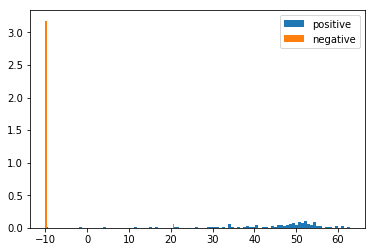

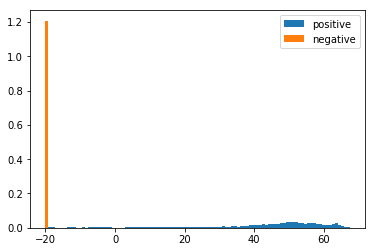

In [8]:
for i,batch in enumerate(data_generator(test_loader,epoch_size=100,shuffle=False)):
    res = test_fn(*batch)
    if(i == 0):
        p =res[-1]
        n = res[-2]
    p = np.concatenate((p,res[-1]))
    n = np.concatenate((n,res[-2]))
plt.hist(np.clip(res[-1],-10,100),100,normed=True,label='positive')
plt.hist(np.clip(res[-2],-10,100),100,normed=True,label='negative')
plt.legend()
plt.show()  
plt.hist(np.clip(p,-20,100),100,normed=True,label='positive')
plt.hist(np.clip(n,-20,100),100,normed=True,label='negative')
plt.legend()
plt.show()

In [28]:
cfg['TRAIN']

{'EPOCH': 0, 'EPOCH_NUM': 20, 'TEST_EPOCH_SIZE': 750, 'TRIN_EPOCH_SIZE': 1500}

In [29]:
import argparse
parser = argparse.ArgumentParser(description='Train gmm segmentation network')

In [33]:

# def iter_all_keys_in_dict(prefix,d):
#     names = []
#     optional = []
#     default = []
#     for k in d.keys():
#         try:
#             d[k].keys()
#             n,o,dflt = iter_all_keys_in_dict((prefix+'_' if( len(prefix) > 0) else '')+k,d[k])
#             names = names+n
#             optional = optional+o
#             default = default+dflt
#         except:
#             names.append((prefix+'.' if( len(prefix) > 0) else '')+k)
#             optional.append(not (d[k] is None))
#             default.append(d[k])
            
#     return names,optional,default
        

# parser = argparse.ArgumentParser(description='Train gmm segmentation network')
# for name,optional,default in zip(iter_all_keys_in_dict('',cfg)):
#     parser.add_argument('--'+name.lower(), type = type(default),default=default,optional=optional)


# args = parser.parse_args()

(['ndim',
  'NETWORK',
  'SEQ_LENGTH',
  'DATASET.TEST_MINR',
  'DATASET.CASHE_SAMPLES',
  'DATASET.TRAIN_MAXR',
  'DATASET.TRAIN_MINR',
  'DATASET.T_SIZE',
  'DATASET.TEST_MAXR',
  'TRAIN.EPOCH',
  'TRAIN.EPOCH_NUM',
  'TRAIN.TRIN_EPOCH_SIZE',
  'TRAIN.TEST_EPOCH_SIZE',
  'gm_num',
  'OUT_SIZE',
  'TILE_SIZE',
  'NAME_PREFIX',
  'NAME'],
 [True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True],
 [12,
  'conv4_net_dense',
  250,
  0.2,
  True,
  0.3,
  0.2,
  32,
  0.3,
  0,
  20,
  1500,
  750,
  4,
  1,
  9,
  '',
  'conv4_net_dense12'])